# 1. Initializations

## 1.1 General imports

In [1]:
### data management
import pandas as pd
import numpy as np

### graphical matplotlib basics
import matplotlib.pyplot as plt
# for jupyter notebook management
%matplotlib inline
%config Completer.use_jedi = False

### graphical seaborn basics
import seaborn as sns

### graphical plotly basics
# import plotly.graph_objects as go
# import plotly.express as px


## 1.2 General dataframe functions

In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print(f"Projet initialisé depuis : {PROJECT_ROOT}")
from smartcheck import dataframe_common as dfc

Projet initialisé depuis : C:\Users\remyc\PycharmProjects\avr25-mle-velib


## 1.3 General seaborn functions

In [3]:
# None

# 2. Loading and Data Quality

## 2.1 Loading of data sets and general exploration

### 2.1.1 NETFLIX

In [4]:
df_netflix = dfc.load_dataset_from_config('netflix_data', sep=',')

if df_netflix is not None:
    display(df_netflix.head())
    dfc.log_general_info(df_netflix.iloc[:,:])

[INFO] File path resolved from configuration : https://drive.google.com/file/d/1eAbS-j4AtEP1ANeyULklF9IDT6zFKc2E/view?usp=drive_link.
[INFO] File ID extracted from URL: 1eAbS-j4AtEP1ANeyULklF9IDT6zFKc2E


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


[INFO] --------------------
Dataset shape: 8807 rows x 12 columns
********************
[INFO] --------------------
Quantitative variable description:
       release_year
count   8807.000000
mean    2014.180198
std        8.819312
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000
********************
[INFO] --------------------
Quantitative correlation matrix:
              release_year
release_year           1.0
********************
[INFO] --------------------
DataFrame info:

[INFO] ********************
[INFO] --------------------
Rows with at least one NaN: 3475
********************
[INFO] --------------------
Rows with all values NaN: 0
********************
[INFO] --------------------
Duplicate rows (NaN treated as equal): 0 unique, 0 total
********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


### 2.1.2 IMDB

In [5]:
df_imdb = dfc.load_dataset_from_config('imdb_data', sep=',')

if df_imdb is not None:
    display(df_imdb.head())
    dfc.log_general_info(df_imdb.iloc[:,:])

[INFO] File path resolved from configuration : https://drive.google.com/file/d/1v4COX6_Qnh-iQE0FJDPXmwKKz0O7XbyT/view?usp=drive_link.
[INFO] File ID extracted from URL: 1v4COX6_Qnh-iQE0FJDPXmwKKz0O7XbyT


,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
0,No Time to Die,2021,7.6,"107,163","Action, Adventure, Thriller",163.0,Film,PG-13,-,Mild,Moderate,Mild,Mild,Moderate
1,The Guilty,2021,6.3,"64,375","Crime, Drama, Thriller",90.0,Film,R,-,NaN,NaN,Severe,NaN,Moderate
2,The Many Saints of Newark,2021,6.4,"27,145","Crime, Drama",120.0,Film,R,-,Moderate,Severe,Severe,Moderate,Moderate
3,Venom: Let There Be Carnage,2021,6.4,"30,443","Action, Adventure, Sci-Fi",97.0,Film,PG-13,-,NaN,Moderate,Moderate,Mild,Moderate
4,Dune,2021,8.3,"84,636","Action, Adventure, Drama",155.0,Film,PG-13,-,NaN,Moderate,NaN,Mild,Moderate


[INFO] --------------------
Dataset shape: 6178 rows x 14 columns
********************
[INFO] --------------------
Quantitative variable description:
              Date     Duration
count  6178.000000  5877.000000
mean   2005.952574    94.576995
std      15.910248    41.765795
min    1922.000000     2.000000
25%    1998.000000    70.000000
50%    2011.000000   100.000000
75%    2019.000000   116.000000
max    2023.000000   900.000000
********************
[INFO] --------------------
Quantitative correlation matrix:
              Date  Duration
Date      1.000000 -0.053237
Duration -0.053237  1.000000
********************
[INFO] --------------------
DataFrame info:

[INFO] ********************
[INFO] --------------------
Rows with at least one NaN: 3125
********************
[INFO] --------------------
Rows with all values NaN: 0
********************
[INFO] --------------------
Duplicate rows (NaN treated as equal): 1150 unique, 2300 total
********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6178 entries, 0 to 6177
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         6178 non-null   object 
 1   Date         6178 non-null   int64  
 2   Rate         6178 non-null   object 
 3   Votes        6178 non-null   object 
 4   Genre        6178 non-null   object 
 5   Duration     5877 non-null   float64
 6   Type         6178 non-null   object 
 7   Certificate  5728 non-null   object 
 8   Episodes     6178 non-null   object 
 9   Nudity       4719 non-null   object 
 10  Violence     5504 non-null   object 
 11  Profanity    5520 non-null   object 
 12  Alcohol      5407 non-null   object 
 13  Frightening  5320 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 675.8+ KB


[INFO] Detailed duplicate rows with differing NaN columns:
     original_index  duplicate_index  \
0              3878             5028   
1              3880             5030   
2              3882             5032   
3              3884             5034   
4              3886             5036   
..              ...              ...   
622            5017             6167   
623            5020             6170   
624            5022             6172   
625            5024             6174   
626            5026             6176   

                                   nan_columns  
0                                [Frightening]  
1                          [Nudity, Profanity]  
2    [Nudity, Profanity, Alcohol, Frightening]  
3                 [Nudity, Profanity, Alcohol]  
4                                [Frightening]  
..                                         ...  
622             [Nudity, Alcohol, Frightening]  
623                              [Frightening]  
624                

## 2.2 Data quality refinement

### 2.2.1 NETFLIX

In [6]:
df_netflix_orig = df_netflix.copy()
df_netflix = df_netflix.drop_duplicates()

In [7]:
# df_netflix = df_netflix_orig.copy()

In [8]:
# Analysis of variable rating
dfc.display_variable_info(df_netflix.rating)
print("valeur la plus représentée :",df_netflix.rating.mode()[0])
df_netflix.rating = df_netflix.rating.fillna(df_netflix.rating.mode()[0])

[INFO] Analysis for Series [rating]:
[INFO] Sorted unique values: ['66 min', '74 min', '84 min', 'G', 'NC-17', 'NR', 'PG', 'PG-13', 'R', 'TV-14', 'TV-G', 'TV-MA', 'TV-PG', 'TV-Y', 'TV-Y7', 'TV-Y7-FV', 'UR', nan]
[INFO] Value distribution:
rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64


valeur la plus représentée : TV-MA


In [9]:
# Analysis of variable director
dfc.display_variable_info(df_netflix.director[:10])
print("valeur la plus représentée :",df_netflix.director.mode()[0])
# pas de changement avec la valeur la plus représentée pour ne pas altérer la répartition des données

[INFO] Analysis for Series [director]:
[INFO] Sorted unique values: ['Andy Devonshire', 'Haile Gerima', 'Julien Leclercq', 'Kirsten Johnson', 'Mike Flanagan', 'Robert Cullen, José Luis Ucha', 'Theodore Melfi', nan]
[INFO] Value distribution:
director
Kirsten Johnson                  1
Julien Leclercq                  1
Mike Flanagan                    1
Robert Cullen, José Luis Ucha    1
Haile Gerima                     1
Andy Devonshire                  1
Theodore Melfi                   1
Name: count, dtype: int64


valeur la plus représentée : Rajiv Chilaka


### 2.2.1 IMDB

In [10]:
df_imdb['averageRating'] = pd.to_numeric(df_imdb.Rate, errors='coerce')
dfc.display_variable_info(df_imdb.averageRating.sort_values(ascending=False).head(10))

df_imdb['numVotes'] = pd.to_numeric(df_imdb.Votes.str.replace(',', ''), errors='coerce')
dfc.display_variable_info(df_imdb.numVotes.sort_values(ascending=False).head(10))

df_imdb = df_imdb.drop_duplicates()

[INFO] Analysis for Series [averageRating]:
[INFO] Sorted unique values: [9.2, 9.3, 9.4, 9.5, 9.6, 9.7]
[INFO] Value distribution:
averageRating
9.3    4
9.6    2
9.7    1
9.5    1
9.4    1
9.2    1
Name: count, dtype: int64
[INFO] Analysis for Series [numVotes]:
[INFO] Sorted unique values: [1715063.0, 1736338.0, 1767660.0, 1885776.0, 1912582.0, 1915230.0, 1948261.0, 2178860.0, 2428117.0, 2474122.0]
[INFO] Value distribution:
numVotes
2474122.0    1
2428117.0    1
2178860.0    1
1948261.0    1
1915230.0    1
1912582.0    1
1885776.0    1
1767660.0    1
1736338.0    1
1715063.0    1
Name: count, dtype: int64


## 2.3 Data combination and rework

In [11]:
all_content = pd.merge(df_netflix, df_imdb, left_on = ['title','release_year'], right_on = ['Name','Date'], how='inner')
display(all_content.head())
all_movies = all_content[all_content.type=='Movie'].copy()
all_movies['duration'] = all_movies.duration.apply(lambda dur: dur.replace(' min', '')).astype(int)
display(all_movies.head())

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening,averageRating,numVotes
0,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,...,Film,PG,-,NaN,Mild,NaN,NaN,Mild,7.0,2247.0
1,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,...,Film,PG-13,-,Mild,NaN,Mild,Mild,NaN,6.3,6994.0
2,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,...,Film,NaN,-,No Rate,No Rate,No Rate,No Rate,No Rate,5.4,514.0
3,s15,TV Show,Crime Stories: India Detectives,NaN,NaN,NaN,"September 22, 2021",2021,TV-MA,1 Season,...,Series,TV-MA,4,No Rate,No Rate,No Rate,No Rate,No Rate,7.4,646.0
4,s19,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",NaN,"September 22, 2021",2021,TV-14,94 min,...,Film,TV-14,-,NaN,Mild,Mild,Mild,Moderate,5.2,8561.0


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening,averageRating,numVotes
0,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91,...,Film,PG,-,NaN,Mild,NaN,NaN,Mild,7.0,2247.0
1,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104,...,Film,PG-13,-,Mild,NaN,Mild,Mild,NaN,6.3,6994.0
2,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127,...,Film,NaN,-,No Rate,No Rate,No Rate,No Rate,No Rate,5.4,514.0
4,s19,Movie,Intrusion,Adam Salky,"Freida Pinto, Logan Marshall-Green, Robert Joh...",NaN,"September 22, 2021",2021,TV-14,94,...,Film,TV-14,-,NaN,Mild,Mild,Mild,Moderate,5.2,8561.0
6,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103,...,Film,PG-13,-,Mild,Mild,Mild,Mild,NaN,6.0,237673.0


# 2. Data Viz' and Analysis

## 2.1 General Data Viz'

### 2.1.1 Seaborn

In [12]:
sns.set_theme(style = "ticks", context = "talk", palette = "bright")

## 2.1 Quantitative mono variable distribution

### 2.1.2 Seaborn

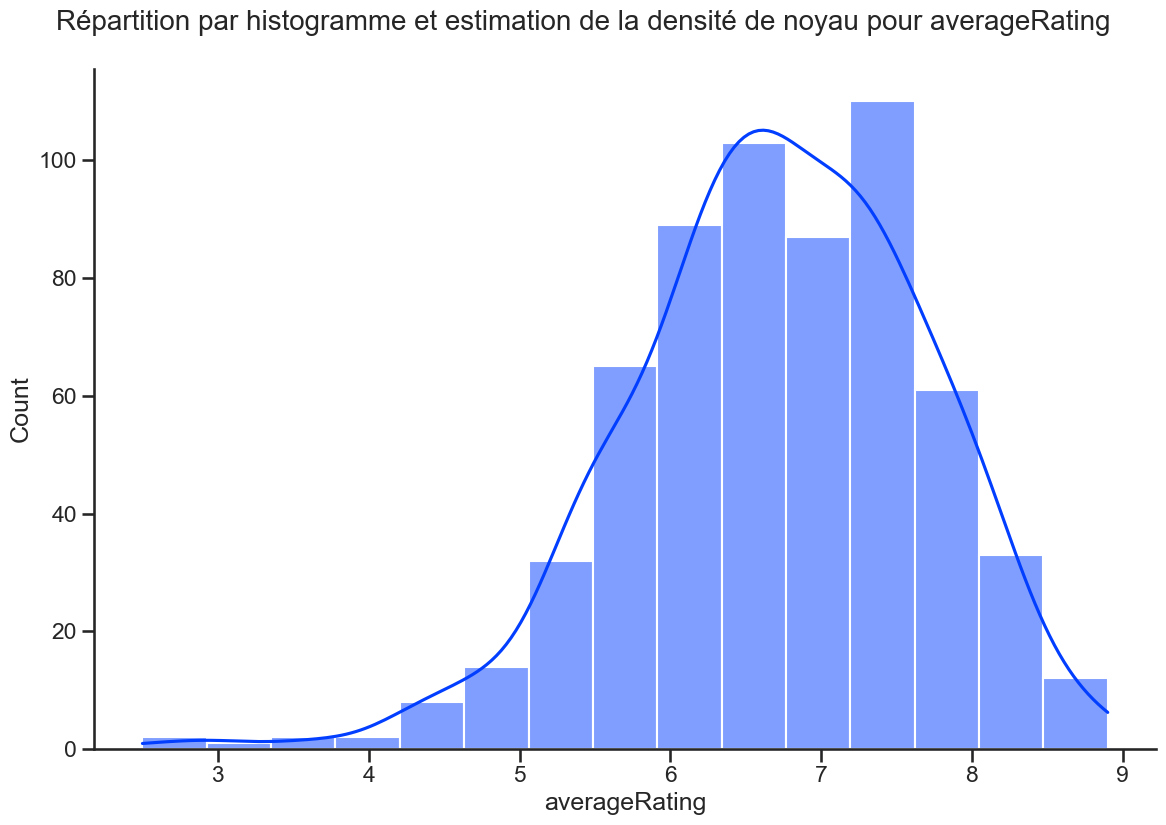

In [13]:
graph = sns.displot(
    data=all_movies,
    x=all_movies.averageRating.name,
    kind='hist',
    bins=15,
    kde=True,
    height=8,
    aspect=1.5
)
graph.fig.suptitle(
    'Répartition par histogramme et estimation de la densité de noyau pour averageRating',
    y=1.04,
    fontsize=20
)

plt.show()

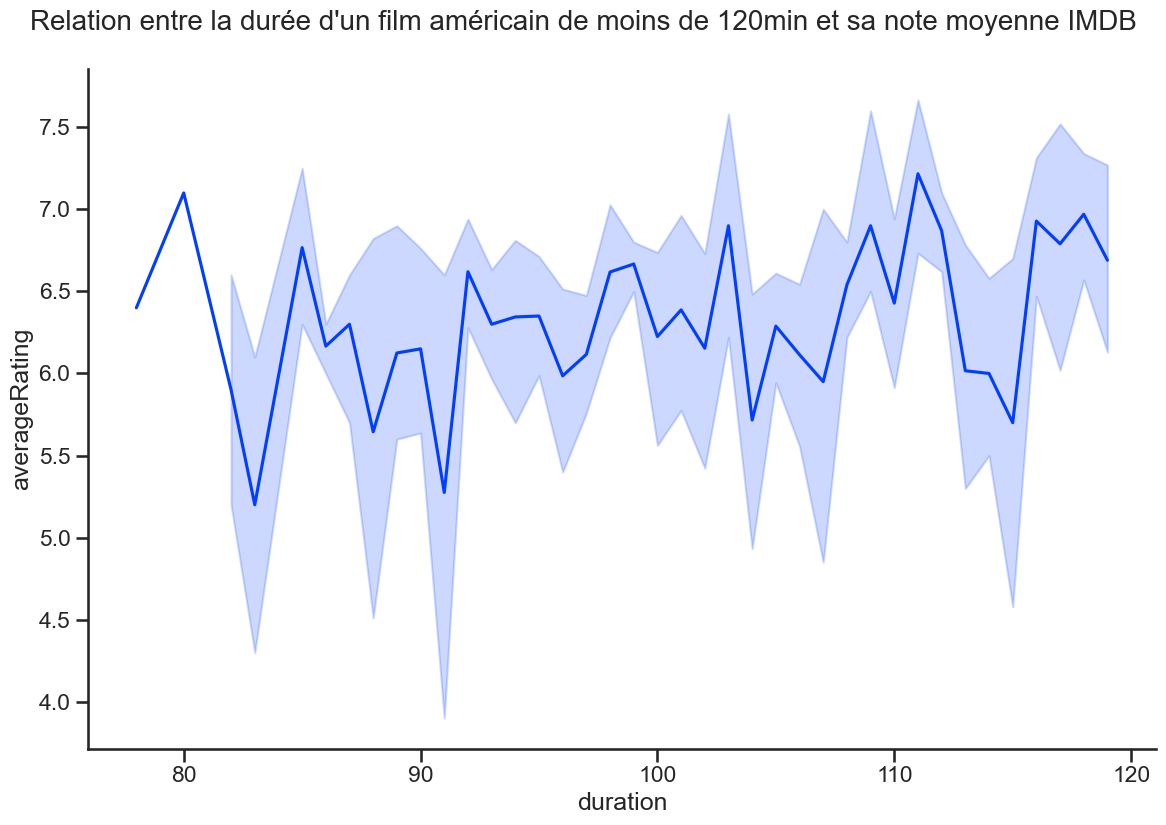

In [14]:
graph = sns.relplot(
    data=all_movies[(all_movies.country=='United States')&(all_movies.duration<120)],
    x=all_movies.duration.name,
    y=all_movies.averageRating.name,
    kind='line',
    height=8,
    aspect=1.5
)
graph.fig.suptitle(
    'Relation entre la durée d\'un film américain de moins de 120min et sa note moyenne IMDB',
    y=1.04,
    fontsize=20
)

plt.show()

## 2.2 Qualitative mono variable distribution

### 2.2.3 Seaborn

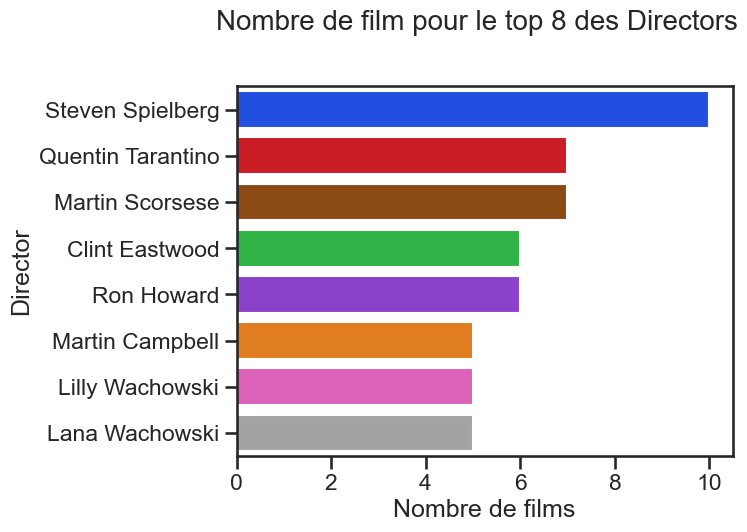

In [15]:
# data extraction
directors = all_content.director.str.split(', ', expand=True).stack().reset_index(drop=True)
top_directors_list = directors.value_counts().head(8)
top_directors = pd.DataFrame(directors)
top_directors.columns = ['Director']

graph = sns.countplot(
    data=top_directors[top_directors.Director.isin(top_directors_list.index)],
    y=top_directors.Director.name, # affichage horizontal
    order=top_directors_list.index,
    hue=top_directors[top_directors.Director.isin(top_directors_list.index)].Director,
    legend=False
)
graph.axes.set_xticks(np.arange(0, 11, 2))
graph.axes.set_xlabel('Nombre de films')
graph.figure.suptitle('Nombre de film pour le top 8 des Directors', y=1.04, fontsize=20)

plt.show()

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


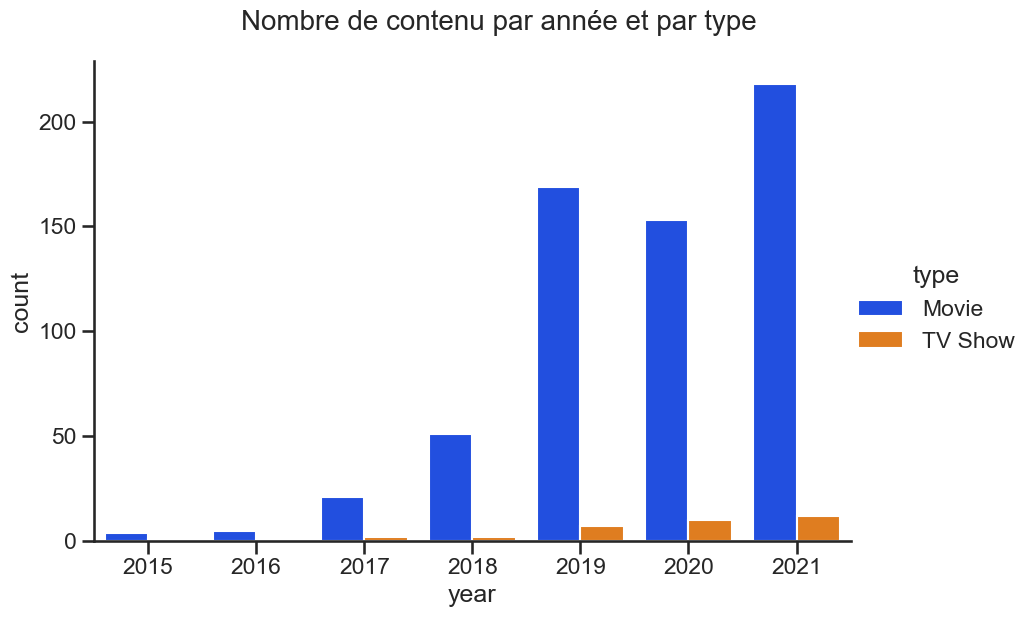

In [16]:
# data extraction
all_content["year"] = pd.to_datetime(all_content.date_added.str.strip()).dt.year

graph = sns.catplot(
    data=all_content,
    x=all_content.year.name,
    kind='count',
    hue=all_content.type.name,
    height=6,
    aspect=1.5
)
graph.figure.suptitle('Nombre de contenu par année et par type', y=1.04, fontsize=20)

plt.show()

## 2.3 Qualitative multi variable distribution

### 2.3.3 Seaborn

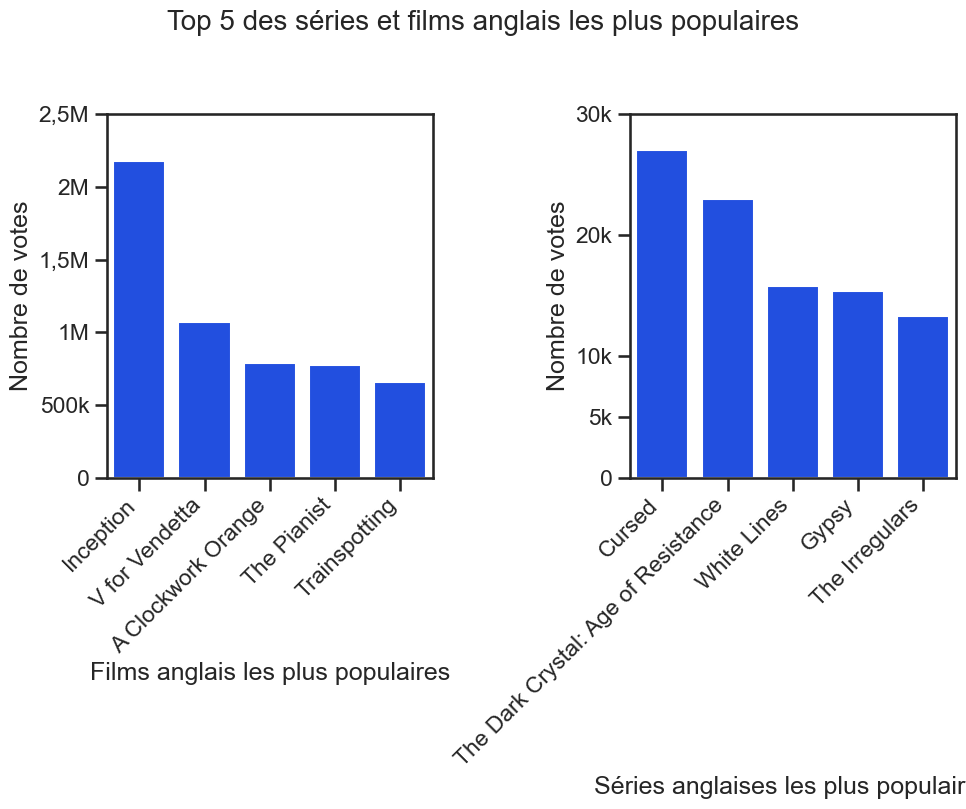

In [17]:
# data extraction
uk_movies = all_content.loc[(all_content.type=="Movie") & (all_content.country.str.contains('United Kingdom'))]
uk_series = all_content.loc[(all_content.type=="TV Show") & (all_content.country.str.contains('United Kingdom'))]

uk_movies = uk_movies.sort_values(by='numVotes', ascending=False)
uk_series = uk_series.sort_values(by='numVotes', ascending=False)

# Afficher côte à côte deux graphiques.
fig, axs = plt.subplots(figsize=(10, 8), nrows=1, ncols=2)
sns.barplot(
    data=uk_movies[:5]
    ,x=uk_movies.Name.name
    ,y=uk_movies.numVotes.name
    ,ax=axs[0]
)
sns.barplot(
    data=uk_series[:5]
    ,x=uk_series.Name.name
    ,y=uk_series.numVotes.name
    ,ax=axs[1]
)

# inclinaison des valeurs X et Y
axs[0].tick_params(axis='x', labelrotation=45)
for label in axs[0].get_xticklabels():
    label.set_ha('right')
axs[1].tick_params(axis='x', labelrotation=45)
for label in axs[1].get_xticklabels():
    label.set_ha('right')

# modification des valeurs affichées pour Y (votes)
axs[0].set_yticks(
    [0, 500000, 1000000, 1500000, 2000000, 2500000]
    ,['0', '500k', '1M', '1,5M', '2M', '2,5M']
)
axs[1].set_yticks(
    [0, 5000, 10000, 20000, 30000]
    ,['0', '5k', '10k', '20k', '30k']
)

# modification des labels X et Y
axs[0].set_xlabel("Films anglais les plus populaires")
axs[1].set_xlabel("Séries anglaises les plus populaires")
axs[0].set_ylabel("Nombre de votes")
axs[1].set_ylabel("Nombre de votes")

# ajout du titre
fig.suptitle('Top 5 des séries et films anglais les plus populaires', y=1.02, fontsize=20)

plt.tight_layout()
plt.show()

## 2.4 Quantitative multi variable correlation

### 2.4.2 Seaborn

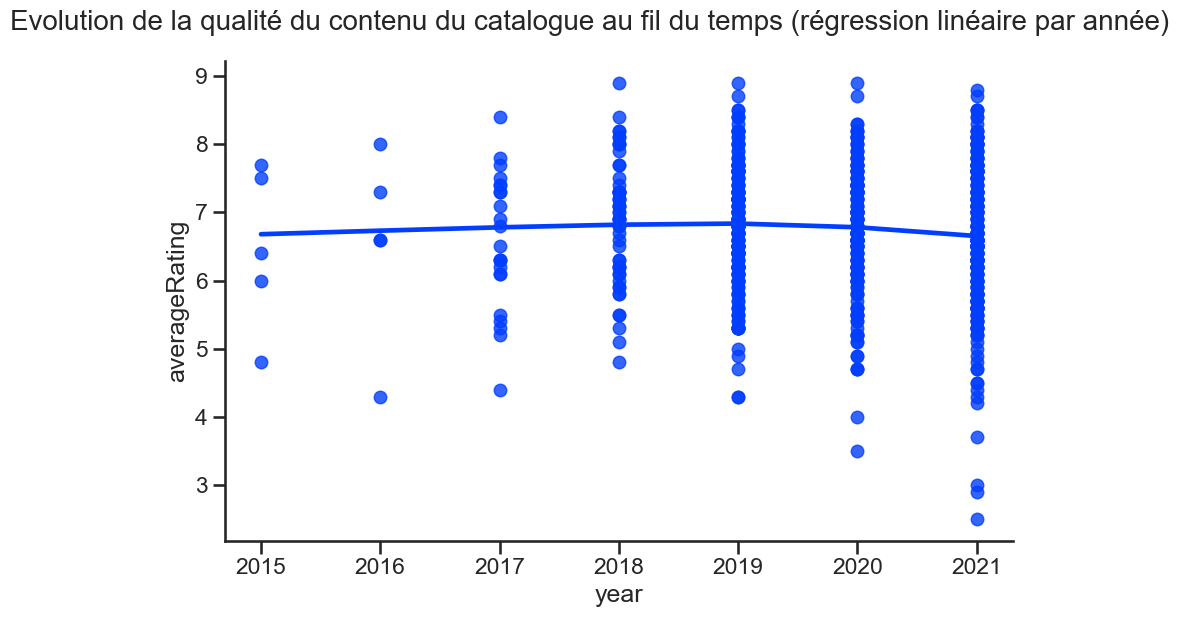

In [18]:
# data extraction
all_content["year"] = pd.to_datetime(all_content.date_added.str.strip()).dt.year

graph = sns.lmplot(
    data=all_content,
    x=all_content.year.name,
    y=all_content.averageRating.name,
    lowess=True,
    height=6,
    aspect=1.5
)
graph.figure.suptitle(
    'Evolution de la qualité du contenu du catalogue au fil du temps (régression linéaire par année)',
    y=1.04,
    fontsize=20)

plt.show()